In [1]:
import os
import sys
import time
import itertools
import numpy as np

# Torch
import torch
from torch import nn
import torch.optim as optim
from torch.autograd import Variable
print("Torch Version:", torch.__version__)

sys.path.append("../../")

# Planning
sys.path.append("../Planning/")
import Planners as Planners

# Control
sys.path.append("../Acting/")
import TrajectorySamplers as TrajectorySamplers

# Model
sys.path.append("../Learning/")
import Models as Models
from Models import weights_init

# Simple RL
from simple_rl.tasks import NavigationWorldMDP
from simple_rl.tasks.navigation.NavigationWorldMDP import NavigationWorldMDP, generate_states, NavigationWorldState

# IRL
sys.path.append("../MLIRL")
from MLIRL import MLIRL

# MaxEnt
sys.path.append("../MaxEntIRL")
from MaxEntIRL import *

# Eval
sys.path.append("../utils/")
from Evaluation import *

from helper import convert_to_grid, plot_irl_gridworld, plot_irl_results

import matplotlib.pyplot as plt
import matplotlib.style as style
from mpl_toolkits.axes_grid1 import make_axes_locatable
# style.use('classic')
%matplotlib inline

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.grid'] = False
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['figure.figsize'] = 15, 55

%matplotlib inline
%load_ext autoreload
%autoreload 2

Torch Version: 0.5.0a0+ab6afc2


# Expert Demonstrations

(<Figure size 1152x576 with 4 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12f8d5908>)

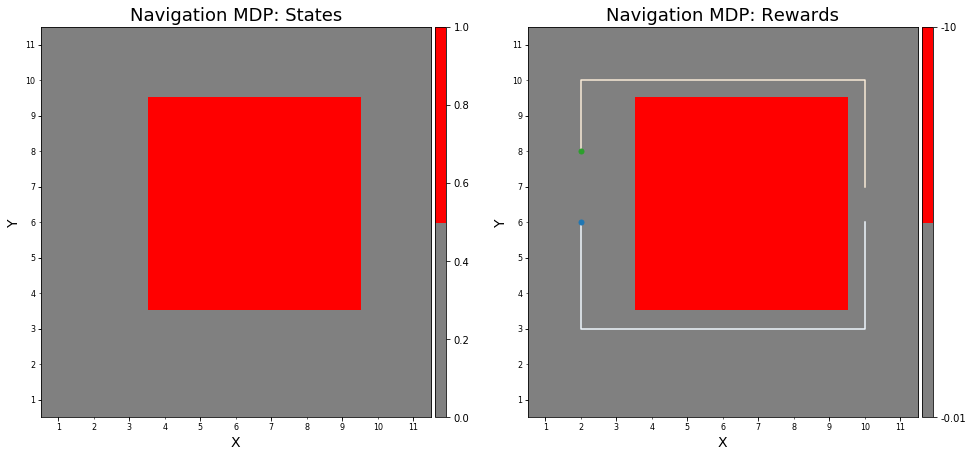

In [2]:
np.random.seed(1)
torch.manual_seed(1)
W, H = 11,11
obstacle = lambda x, y, w, h: [(x+i, y+j) for j in range(h) for i in range(w)]
state_cells = list(itertools.chain(*[o() for o in generate_states(
                              W, H, n_states=1, 
                              obstacle_w_mu=W, obstacle_w_std=0.0, 
                              obstacle_h_mu=H, obstacle_h_std=0.0,
                              buffer_w=0, buffer_h=0, max_search_tries=1)]))
nvmdp_real = NavigationWorldMDP(
    
    width = W, height = H,
    nav_cell_types = ["gray", "red"],
    nav_cell_rewards = [-0.01, -10], # To create separate indicator feature for each obstacle cell.
    nav_cell_p_or_locs = [1., obstacle(4,4,6,6)],
    goal_cell_types = [],
    goal_cell_rewards = [],
    goal_cell_locs = [],
    slip_prob = 0.0, step_cost = 0,
    gamma = 0.95
)

def shortest_path_fn(s, g, nvmdp, living_reward=-0.01):
    
    R_s = nvmdp._reward_func_state_only
    T = nvmdp.transition_func
    A = nvmdp.get_actions()
    return Planners.astar_find_path(
        s, g, A, T, cost_fn=lambda s: -R_s(s),
        heuristic_fn=lambda s1, s2: (living_reward) * np.linalg.norm(np.array(s1) - np.array(s2)))

trajectories = TrajectorySamplers.sample_shortest_path_trajectories(
    [NavigationWorldState(2,6), NavigationWorldState(2,8)], [NavigationWorldState(10,6), NavigationWorldState(10,7)], 
    lambda s,g,mdp=nvmdp_real: shortest_path_fn(s,g,mdp))
trajectories_states = [list(zip(*traj))[0] for traj in trajectories]

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121)
fig, ax = nvmdp_real.visualize_grid(fig=fig, ax=ax, 
                                    show_colorbar=True, 
                                    subplot_str="121", title="Navigation MDP: States")
ax = fig.add_subplot(122)
nvmdp_real.visualize_grid(fig=fig, ax=ax, trajectories=trajectories_states,
                          show_colorbar=True, show_rewards_colorbar=True, 
                          subplot_str="122", title="Navigation MDP: Rewards")

# IRL Navigation MDP

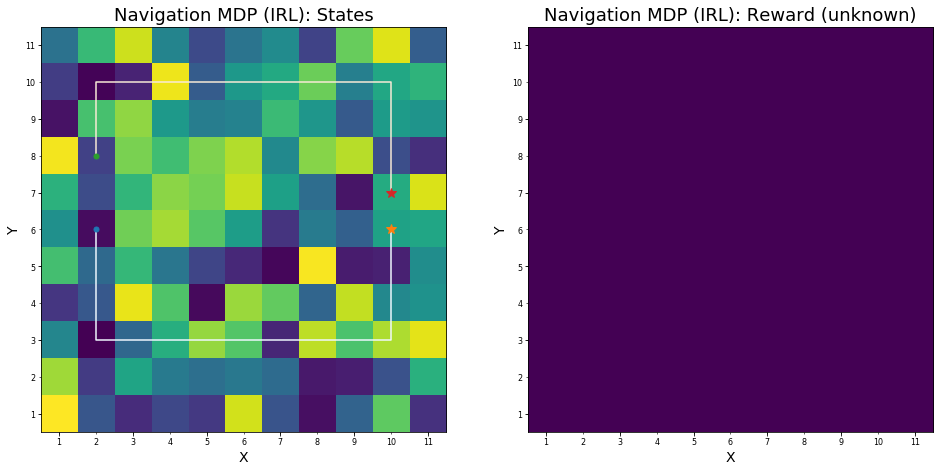

In [3]:
nvmdp_irl = NavigationWorldMDP(
    
    width = W, height = H,
    nav_cell_types = [*range(len(state_cells))],
    nav_cell_rewards = [*[-0.01]*len(state_cells)], # To create separate indicator feature for each obstacle cell.
    nav_cell_p_or_locs = [*[[o] for o in state_cells]],
    goal_cell_types = [],
    goal_cell_rewards = [],
    goal_cell_locs = [],
    slip_prob = 0.0, step_cost = 0,
    gamma = 0.95
)
# shuffle state ids for better cmap representation of our problem.
nvmdp_irl.map_state_cell_id = np.random.permutation(
    nvmdp_irl.map_state_cell_id.reshape(1,-1).squeeze()).reshape(nvmdp_irl.height, nvmdp_irl.width)

## MDP Params ------------------
# States
S = nvmdp_irl.get_all_states()
s_to_idx = {v:k for k,v in enumerate(S)}
# Rewards
R_s = nvmdp_irl._reward_func_state_only
R = torch.tensor([float(R_s(s)) for s in S], requires_grad=True)
R_grid = convert_to_grid(nvmdp_irl, S, R)
# Actions
A = nvmdp_irl.get_actions()
a_to_idx = {a:i for i,a in enumerate(A)}
# Dynamics
T = nvmdp_irl.transition_func
# Features
state_ids = [nvmdp_irl.map_state_cell_id[nvmdp_irl._xy_to_rowcol(*s)] for s in S]
# linear_phi = torch.FloatTensor([state_id_to_linear_feature(s_id) for s_id in state_ids])
# non_linear_phi = torch.FloatTensor([state_id_to_non_linear_feature(s_id) for s_id in state_ids])
one_hot_phi = torch.FloatTensor([nvmdp_irl.feature_at_state(s) for s in S])
phi = one_hot_phi
phi_fn = lambda s: phi[s_to_idx[s]]
def states_generator(trajectory):
    return S

def dynamics_generator(trajectory):
    return lambda s,a: [(T(s,a), 1.)]
# -------------------------------

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121)
fig, ax = nvmdp_irl.visualize_grid(fig=fig, ax=ax, cmap=plt.cm.viridis, plot=False,
                                   trajectories=trajectories_states,
                                   init_marker=".", end_marker="*",
                                   title="Navigation MDP (IRL): States")
ax = fig.add_subplot(122)
_ = nvmdp_irl.visualize_grid(fig=fig, ax=ax, cmap=plt.cm.viridis, 
                             title="Navigation MDP (IRL): Reward (unknown)", values=R_grid, 
                             state_space_cmap=False)

# MaxEnt IRL

In [12]:
lr, weight_decay = 0.1, 0
phi_dim = len(phi_fn(S[0]))
temperature = 1 # Not needed in MaxEnt
gamma = 0.95
n_vi_iters = 400
n_maxent_iters = 200
vi_convergence_eps = 1e-4

np.random.seed(1)
torch.manual_seed(1)
# R model
R_model = Models.LinearRewardModel_ReLU(phi_dim)
R_model.apply(weights_init)

with torch.no_grad():
    R_grid_init = convert_to_grid(nvmdp_irl, S, torch.tensor([R_model(phi_fn(s)) for s in S], requires_grad=False))

# Test: non-positive R
assert np.alltrue(np.asarray([R_model(torch.FloatTensor(x)).item() for x in np.random.uniform(-10,10,(100,phi_dim))]) <= 0)
# Optimizer
optimizer_fn=lambda params, lr, weight_decay: optim.Adam(params, lr=lr, weight_decay=weight_decay)
R_optimizer = optimizer_fn(R_model.parameters(), lr, weight_decay)

maxent_loss_history, maxent_learned_policies, maxent_log_likelihoods = MaxEntIRL(
    trajectories, states_generator, dynamics_generator, A, phi_fn, 
    R_model, R_optimizer, gamma, n_maxent_iters, n_vi_iters, boltzmann_temp=temperature,
    verbose=True, debug=False, insane_debug=False, vi_convergence_eps=vi_convergence_eps)

MaxEntIRL params 
-----
	 Domains: 2, sizes: [121, 121],
	 Action dim: 4, 
	 Feature dim: 121,
	 Iterations: 200, 
	 Max likelihood: 0.99,
	 VI iterations: 400, 
	 VI convergence eps: 0.0001,
	 Gamma (discount factor): 0.95,
Running Backward Pass  [ ... ] Backward pass converged @ 110.
Running Backward Pass  [ ... ] Backward pass converged @ 111.

>>> Iter: 0000 (1.635s): loss = 00.012863, likelihood = 0.0000
Running Backward Pass  [ ... ] Backward pass converged @ 108.
Running Backward Pass  [ ... ] Backward pass converged @ 108.

>>> Iter: 0001 (1.642s): loss = 00.011933, likelihood = 0.0000
Running Backward Pass  [ ... ] Backward pass converged @ 105.
Running Backward Pass  [ ... ] Backward pass converged @ 105.

>>> Iter: 0002 (1.613s): loss = 00.010580, likelihood = 0.0000
Running Backward Pass  [ ... ] Backward pass converged @ 103.
Running Backward Pass  [ ... ] Backward pass converged @ 103.

>>> Iter: 0003 (1.500s): loss = 00.009457, likelihood = 0.0000
Running Backward Pass  

Running Backward Pass  [ ... ] Backward pass converged @ 103.

>>> Iter: 0042 (1.378s): loss = 00.003016, likelihood = 0.0000
Running Backward Pass  [ ... ] Backward pass converged @ 102.
Running Backward Pass  [ ... ] Backward pass converged @ 103.

>>> Iter: 0043 (1.434s): loss = 00.003007, likelihood = 0.0000
Running Backward Pass  [ ... ] Backward pass converged @ 102.
Running Backward Pass  [ ... ] Backward pass converged @ 103.

>>> Iter: 0044 (1.442s): loss = 00.002998, likelihood = 0.0000
Running Backward Pass  [ ... ] Backward pass converged @ 102.
Running Backward Pass  [ ... ] Backward pass converged @ 103.

>>> Iter: 0045 (1.470s): loss = 00.002991, likelihood = 0.0000
Running Backward Pass  [ ... ] Backward pass converged @ 102.
Running Backward Pass  [ ... ] Backward pass converged @ 103.

>>> Iter: 0046 (1.448s): loss = 00.002984, likelihood = 0.0000
Running Backward Pass  [ ... ] Backward pass converged @ 102.
Running Backward Pass  [ ... ] Backward pass converged @ 103

Running Backward Pass  [ ... ] Backward pass converged @ 102.
Running Backward Pass  [ ... ] Backward pass converged @ 103.

>>> Iter: 0086 (1.442s): loss = 00.002844, likelihood = 0.0000
Running Backward Pass  [ ... ] Backward pass converged @ 102.
Running Backward Pass  [ ... ] Backward pass converged @ 103.

>>> Iter: 0087 (1.427s): loss = 00.002843, likelihood = 0.0000
Running Backward Pass  [ ... ] Backward pass converged @ 101.
Running Backward Pass  [ ... ] Backward pass converged @ 103.

>>> Iter: 0088 (1.410s): loss = 00.002842, likelihood = 0.0000
Running Backward Pass  [ ... ] Backward pass converged @ 102.
Running Backward Pass  [ ... ] Backward pass converged @ 103.

>>> Iter: 0089 (1.439s): loss = 00.002840, likelihood = 0.0000
Running Backward Pass  [ ... ] Backward pass converged @ 102.
Running Backward Pass  [ ... ] Backward pass converged @ 103.

>>> Iter: 0090 (1.443s): loss = 00.002839, likelihood = 0.0000
Running Backward Pass  [ ... ] Backward pass converged @ 102

Running Backward Pass  [ ... ] Backward pass converged @ 102.
Running Backward Pass  [ ... ] Backward pass converged @ 103.

>>> Iter: 0130 (1.442s): loss = 00.002801, likelihood = 0.0000
Running Backward Pass  [ ... ] Backward pass converged @ 102.
Running Backward Pass  [ ... ] Backward pass converged @ 103.

>>> Iter: 0131 (1.415s): loss = 00.002801, likelihood = 0.0000
Running Backward Pass  [ ... ] Backward pass converged @ 101.
Running Backward Pass  [ ... ] Backward pass converged @ 103.

>>> Iter: 0132 (1.389s): loss = 00.002800, likelihood = 0.0000
Running Backward Pass  [ ... ] Backward pass converged @ 102.
Running Backward Pass  [ ... ] Backward pass converged @ 103.

>>> Iter: 0133 (1.416s): loss = 00.002799, likelihood = 0.0000
Running Backward Pass  [ ... ] Backward pass converged @ 102.
Running Backward Pass  [ ... ] Backward pass converged @ 103.

>>> Iter: 0134 (1.492s): loss = 00.002799, likelihood = 0.0000
Running Backward Pass  [ ... ] Backward pass converged @ 102

Running Backward Pass  [ ... ] Backward pass converged @ 102.
Running Backward Pass  [ ... ] Backward pass converged @ 103.

>>> Iter: 0174 (1.496s): loss = 00.002781, likelihood = 0.0000
Running Backward Pass  [ ... ] Backward pass converged @ 102.
Running Backward Pass  [ ... ] Backward pass converged @ 103.

>>> Iter: 0175 (1.550s): loss = 00.002781, likelihood = 0.0000
Running Backward Pass  [ ... ] Backward pass converged @ 101.
Running Backward Pass  [ ... ] Backward pass converged @ 103.

>>> Iter: 0176 (1.477s): loss = 00.002780, likelihood = 0.0000
Running Backward Pass  [ ... ] Backward pass converged @ 102.
Running Backward Pass  [ ... ] Backward pass converged @ 103.

>>> Iter: 0177 (1.456s): loss = 00.002780, likelihood = 0.0000
Running Backward Pass  [ ... ] Backward pass converged @ 102.
Running Backward Pass  [ ... ] Backward pass converged @ 103.

>>> Iter: 0178 (1.450s): loss = 00.002780, likelihood = 0.0000
Running Backward Pass  [ ... ] Backward pass converged @ 101

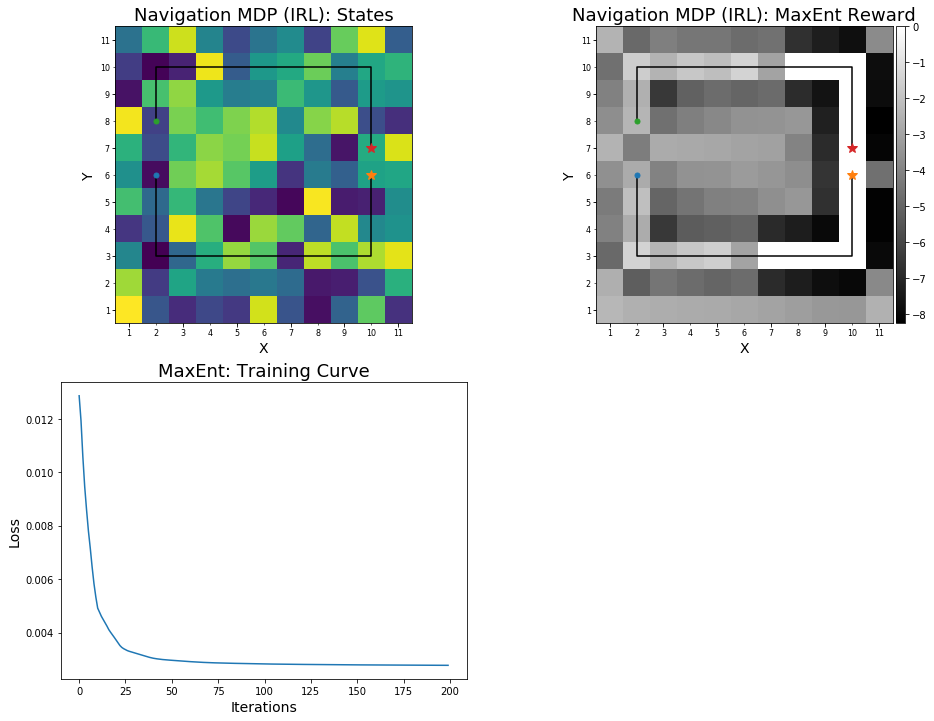

In [13]:
maxent_R_grid = convert_to_grid(nvmdp_irl, S, torch.tensor([R_model(phi_fn(s)) for s in S], requires_grad=False))

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(221)
fig, ax = nvmdp_irl.visualize_grid(fig=fig, ax=ax, cmap=plt.cm.viridis, plot=False, 
                                   trajectories=trajectories_states,
                                   init_marker=".", end_marker="*", 
                                   traj_marker="-k", traj_colors_auto=False,
                                   title="Navigation MDP (IRL): States")
ax = fig.add_subplot(222)
_ = nvmdp_irl.visualize_grid(fig=fig, ax=ax, cmap=plt.cm.gray, show_colorbar=True, plot=False,
                             trajectories=trajectories_states,
                             init_marker=".", end_marker="*", 
                             traj_marker="-k", traj_colors_auto=False,
                             title="Navigation MDP (IRL): MaxEnt Reward", values=maxent_R_grid,
                             state_space_cmap=False)
ax = fig.add_subplot(223)
plt.plot(maxent_loss_history)
plt.ylabel("Loss")
plt.xlabel("Iterations")
plt.title("MaxEnt: Training Curve")
plt.show()

# MLIRL

In [ ]:
lr, weight_decay = 0.1, 0
phi_dim = len(phi_fn(S[0]))
temperature = 1.
gamma = 0.95
n_vi_iters = 400
n_mlirl_iters = 200
vi_convergence_eps = 1e-4

np.random.seed(1)
torch.manual_seed(1)
# R model
R_model = Models.LinearRewardModel_ReLU(phi_dim)
R_model.apply(weights_init)
# for p in R_model.parameters():
#     print(p)
# Test: non-positive R
# assert np.alltrue(np.asarray([R_model(torch.FloatTensor(x)).item() for x in np.random.uniform(-10,10,(100,phi_dim))]) <= 0)
# Optimizer
optimizer_fn=lambda params, lr, weight_decay: optim.Adam(params, lr=lr, weight_decay=weight_decay)
R_optimizer = optimizer_fn(R_model.parameters(), lr, weight_decay)

policy = lambda Q, temp=temperature: Planners.log_boltzmann_dist(Q, temp)

mlirl_loss_history, mlirl_learned_policies = MLIRL(
                trajectories, states_generator, dynamics_generator, A, phi_fn, R_model, R_optimizer, 
                policy, gamma, n_mlirl_iters, n_vi_iters, verbose=True, vi_convergence_eps=vi_convergence_eps)

MLIRL params 
-----
	 Domains: 2, sizes: [121, 121],
	 Action dim: 4, 
	 Feature dim: 121,
	 Iterations: 200, 
	 Max likelihood: 0.99,
	 VI iterations: 400, 
	 VI convergence eps: 0.0001,
	 Gamma (discount factor): 0.95, 
	 Policy example: Q tensor([0.0000, 0.3333, 0.6667, 1.0000]) -> Pi tensor([-1.9547, -1.6213, -1.2880, -0.9547])
Running VI [  ] VI converged @ 24.
Running VI [  ] VI converged @ 25.

>>> Iter: 0000 (4.163s): loss = 24.855486, likelihood = 0.0000
Running VI [  ] VI converged @ 23.
Running VI [  ] VI converged @ 24.

>>> Iter: 0001 (3.911s): loss = 21.033804, likelihood = 0.0000
Running VI [  ] VI converged @ 23.
Running VI [  ] VI converged @ 25.

>>> Iter: 0002 (4.031s): loss = 17.018856, likelihood = 0.0000
Running VI [  ] VI converged @ 24.
Running VI [  ] VI converged @ 26.

>>> Iter: 0003 (4.171s): loss = 13.345436, likelihood = 0.0000
Running VI [  ] VI converged @ 25.
Running VI [  ] VI converged @ 26.

>>> Iter: 0004 (4.530s): loss = 10.981154, likelihood = 0.0

In [ ]:
mlirl_R_grid = convert_to_grid(nvmdp_irl, S, torch.tensor([R_model(phi_fn(s)) for s in S], requires_grad=False))

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(221)
fig, ax = nvmdp_irl.visualize_grid(fig=fig, ax=ax, cmap=plt.cm.viridis, plot=False, 
                                   trajectories=trajectories_states,
                                   init_marker=".", end_marker="*", 
                                   traj_marker="-k", traj_colors_auto=False,
                                   title="Navigation MDP (IRL): States\n" + r"$ \phi(s) = [1_s]^{|S|}, 1_s: S \rightarrow \{0,1\},\forall s \in S$")
ax = fig.add_subplot(222)
_ = nvmdp_irl.visualize_grid(fig=fig, ax=ax, cmap=plt.cm.gray, show_colorbar=True, plot=False,
                             trajectories=trajectories_states,
                             init_marker=".", end_marker="*", 
                             traj_marker="-k", traj_colors_auto=False,
                             title="Navigation MDP (IRL): MLIRL Reward", values=mlirl_R_grid,
                             state_space_cmap=False)
ax = fig.add_subplot(223)
plt.plot(np.exp(-np.asarray(mlirl_loss_history)))
plt.ylabel("Likelihood")
plt.xlabel("Iterations")
plt.title("MLIRL: Training Curve")
plt.show()

In [ ]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(321)
fig, ax = nvmdp_irl.visualize_grid(fig=fig, ax=ax, cmap=plt.cm.viridis, plot=False, 
                                   trajectories=trajectories_states,
                                   init_marker=".", end_marker="*", 
                                   traj_marker="-k", traj_colors_auto=False,
                                   title="Navigation MDP (IRL): States\n" + r"$ \phi(s) = [1_s]^{|S|}, 1_s: S \rightarrow \{0,1\},\forall s \in S$")

ax = fig.add_subplot(322)
fig, ax = nvmdp_irl.visualize_grid(fig=fig, ax=ax, cmap=plt.cm.gray, plot=False, 
                             title="Navigation MDP (IRL): Reward (initial)", values=R_grid_init, 
                             state_space_cmap=False)

ax = fig.add_subplot(323)
plt.plot(mlirl_loss_history, "r", label="loss")
plt.plot(mlirl_loss_history, "ro")
plt.grid(True)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.axis('tight')
plt.legend()
ax_2 = ax.twinx()
plt.plot(np.exp(-np.asarray(mlirl_loss_history)), "g",label="likelihood")
plt.plot(np.exp(-np.asarray(mlirl_loss_history)), "go")
plt.xlabel("Iterations")
plt.ylabel("Likelihood")
plt.legend()
plt.axis('tight')
plt.title("MLIRL: Training Curve")

ax = fig.add_subplot(325)
plt.plot(maxent_loss_history, "r", label="loss")
plt.plot(maxent_loss_history, "ro")
plt.grid(True)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.axis('tight')
plt.legend()
ax_2 = ax.twinx()
plt.plot(np.exp(np.asarray(maxent_log_likelihoods)), "g",label="likelihood")
plt.plot(np.exp(np.asarray(maxent_log_likelihoods)), "go")
plt.xlabel("Iterations")
plt.ylabel("Likelihood")
plt.legend()
plt.axis('tight')
plt.title("MaxEnt: Training Curve")

ax = fig.add_subplot(324)
_ = nvmdp_irl.visualize_grid(fig=fig, ax=ax, cmap=plt.cm.gray, show_colorbar=True, plot=False,
                             trajectories=trajectories_states,
                             init_marker=".", end_marker="*", 
                             traj_marker="-k", traj_colors_auto=False,
                             title="Navigation MDP (IRL): MLIRL Reward", values=mlirl_R_grid,
                             state_space_cmap=False)

ax = fig.add_subplot(326)
_ = nvmdp_irl.visualize_grid(fig=fig, ax=ax, cmap=plt.cm.gray, show_colorbar=True, plot=False,
                             trajectories=trajectories_states,
                             init_marker=".", end_marker="*", 
                             traj_marker="-k", traj_colors_auto=False,
                             title="Navigation MDP (IRL): MaxEnt Reward", values=maxent_R_grid,
                             state_space_cmap=False)